In [1]:
from utils import cp_detector as cpd
from utils import data_generation as gen
from utils import statistic_calculation as stat
from utils import threshold_calculation as th

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2



In [3]:
dataset_parameters = {
    "dataset_size": 500,
    "seq_len": 101,
    "d": 10,
    "p": 5,
    "distribution": "normal",
    "k": 10,
    "cp": None,
    "nu": 10
}

In [14]:
import torch
import torch.nn as nn

data_with_cp, data_without_cp, cp_idxs = gen.generate_data(**dataset_parameters)

### with Layer Norm
layer_norm = nn.LayerNorm(dataset_parameters["d"]).float()
data_with_cp_ln = layer_norm(torch.from_numpy(data_with_cp).float()).detach().numpy()
data_without_cp_ln = (
    layer_norm(torch.from_numpy(data_without_cp).float()).detach().numpy()
)


z_with = stat.calculate_z(data_with_cp)
z_without = stat.calculate_z(data_without_cp)
z_with_ln = stat.calculate_z(data_with_cp_ln)
z_without_ln = stat.calculate_z(data_without_cp_ln)

l_with = stat.calculate_l_lin(z_with, layer_norm=False)
l_without = stat.calculate_l_lin(z_without, layer_norm=False)

l_with_ln = stat.calculate_l_lin(z_with_ln, layer_norm=True)
l_without_ln = stat.calculate_l_lin(z_without_ln, layer_norm=True)

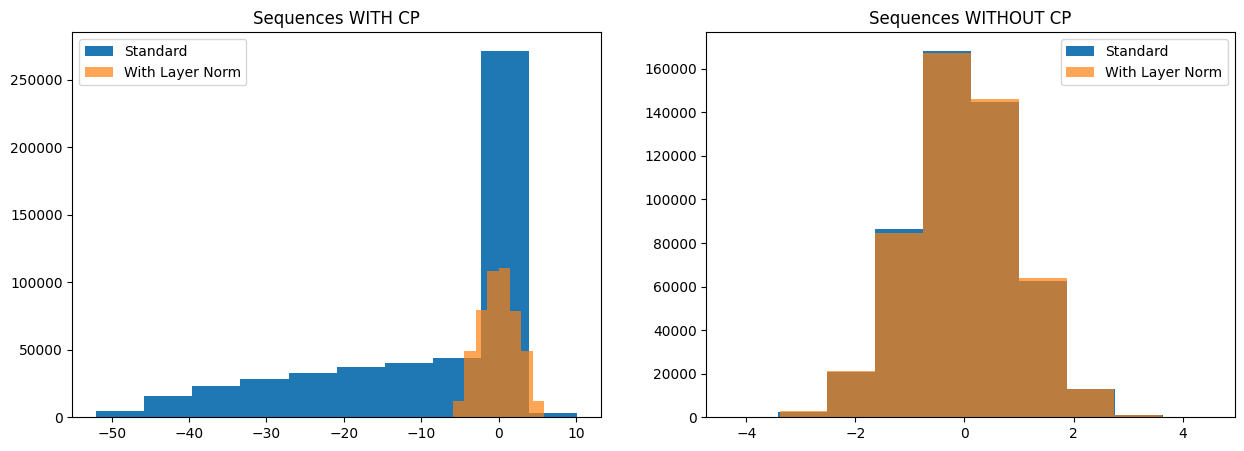

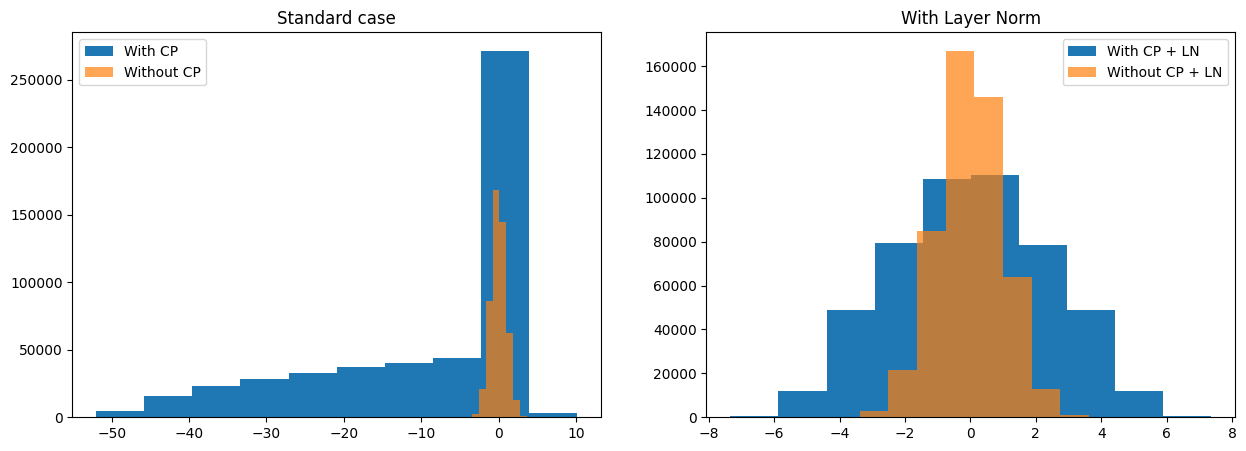

In [11]:
# z-statistic
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Sequences WITH CP")
ax1.hist(z_with.flatten(), label="Standard")
ax1.hist(z_with_ln.flatten(), alpha=0.7, label="With Layer Norm")
ax1.legend()

ax2.set_title("Sequences WITHOUT CP")
ax2.hist(z_without.flatten(), label="Standard")
ax2.hist(z_without_ln.flatten(), alpha=0.7, label="With Layer Norm")
ax2.legend()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Standard case")
ax1.hist(z_with.flatten(), label="With CP")
ax1.hist(z_without.flatten(), alpha=0.7, label="Without CP")
ax1.legend()

ax2.set_title("With Layer Norm")
ax2.hist(z_with_ln.flatten(), label="With CP + LN")
ax2.hist(z_without_ln.flatten(), alpha=0.7, label="Without CP + LN")
ax2.legend();

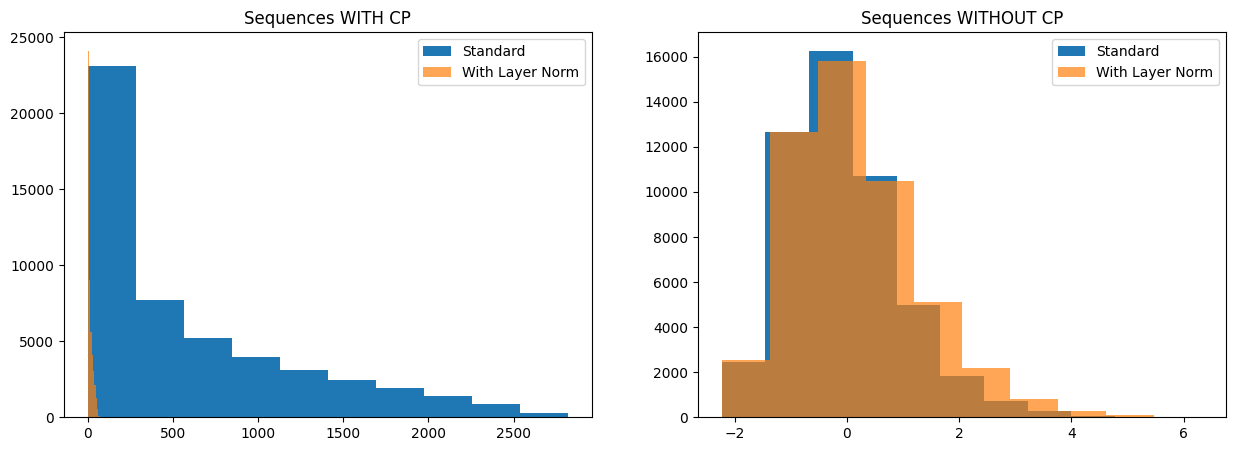

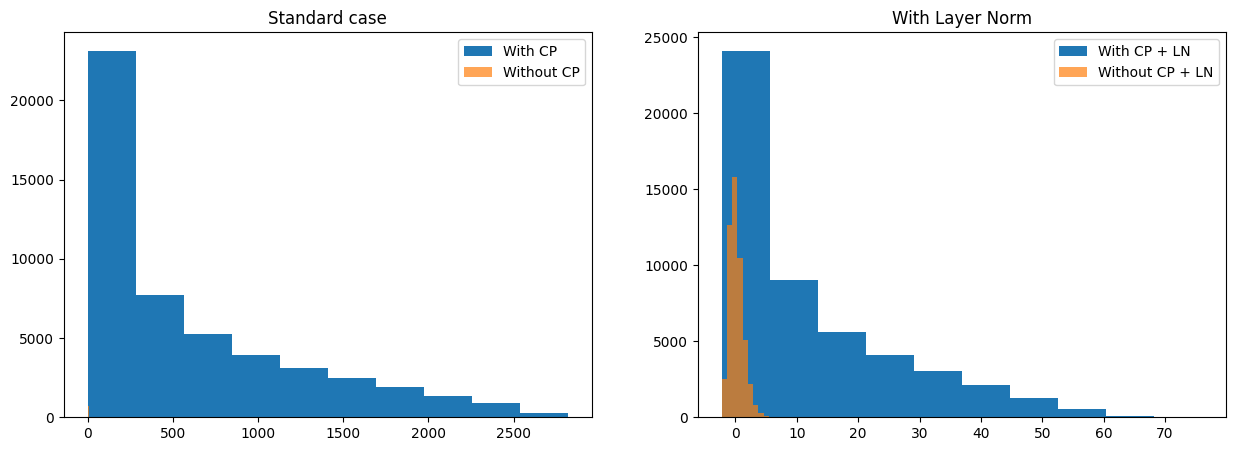

In [12]:
# L-statistic
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Sequences WITH CP")
ax1.hist(l_with.flatten(), label="Standard")
ax1.hist(l_with_ln.flatten(), alpha=0.7, label="With Layer Norm")
ax1.legend()

ax2.set_title("Sequences WITHOUT CP")
ax2.hist(l_without.flatten(), label="Standard")
ax2.hist(l_without_ln.flatten(), alpha=0.7, label="With Layer Norm")
ax2.legend()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Standard case")
ax1.hist(l_with.flatten(), label="With CP")
ax1.hist(l_without.flatten(), alpha=0.7, label="Without CP")
ax1.legend()

ax2.set_title("With Layer Norm")
ax2.hist(l_with_ln.flatten(), label="With CP + LN")
ax2.hist(l_without_ln.flatten(), alpha=0.7, label="Without CP + LN")
ax2.legend();

In [44]:
lin_stat_alpha = {}
lin_stat_alpha_ln = {}
lin_stat_beta = {}
lin_stat_beta_ln = {}

dataset_parameters = {
    "dataset_size": 500,
    "seq_len": 101,
    "d": 10,
    "p": 5,
    "distribution": "t-distribution",
    "k": 0.5,
    "cp": None,
    "nu": 10
}

cp_parameters = {
    "alpha": 0.05,
    "scan": False,
    "data_based": False,
    "ln": False
}

#for d in range(10, 1000, 250):
for d in [100, 500, 1000]:
    print(d)
    dataset_parameters["d"] = d
    (fn, fp), (fn_ln, fp_ln) = cpd.cpd_with_ln_compare(
        dataset_parameters, cp_parameters, data_type="t-distribution"
    )
    lin_stat_alpha[d] = fp
    lin_stat_alpha_ln[d] = fp_ln
    lin_stat_beta[d] = fn
    lin_stat_beta_ln[d] = fn_ln

100
500
1000


In [96]:
dataset_parameters = {
    "dataset_size": 500,
    "seq_len": 101,
    "d": 100,
    "p": 5,
    "distribution": "t-distribution",
    "k": 6,
    "cp": None,
    "nu": 1
}

cp_parameters = {
    "alpha": 0.05,
    "scan": False,
    "data_based": False,
    "ln": False
}

for k in [6]:
    dataset_parameters["k"] = k
    data_with_cp, data_without_cp, cp_idxs = gen.generate_data(**dataset_parameters)
    fn, fp = cpd.detect_true_false_cp(data_with_cp, data_without_cp, dataset_parameters, cp_parameters, data_type="t-distribution")
    print('k ', k, 'fn ', fn, 'fp ', fp)

-19.22462540167105
-19.22462540167105
k  6 fn  0.0 fp  0.0


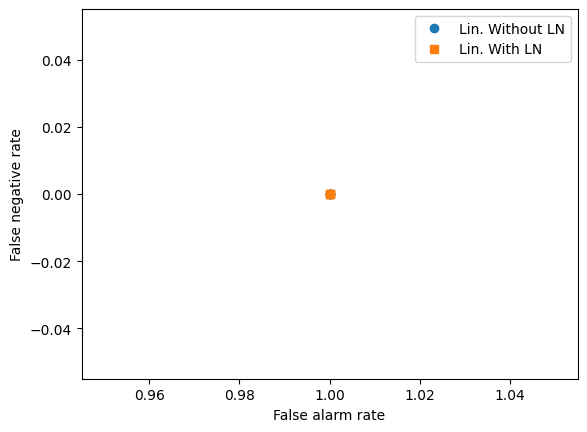

In [45]:
plt.plot(
    [value for value in lin_stat_alpha.values()],
    [value for value in lin_stat_beta.values()],
    "o",
    label="Lin. Without LN",
)

plt.plot(
    [value for value in lin_stat_alpha_ln.values()],
    [value for value in lin_stat_beta_ln.values()],
    "s",
    label="Lin. With LN",
)

plt.xlabel("False alarm rate")
plt.ylabel("False negative rate")
plt.legend()

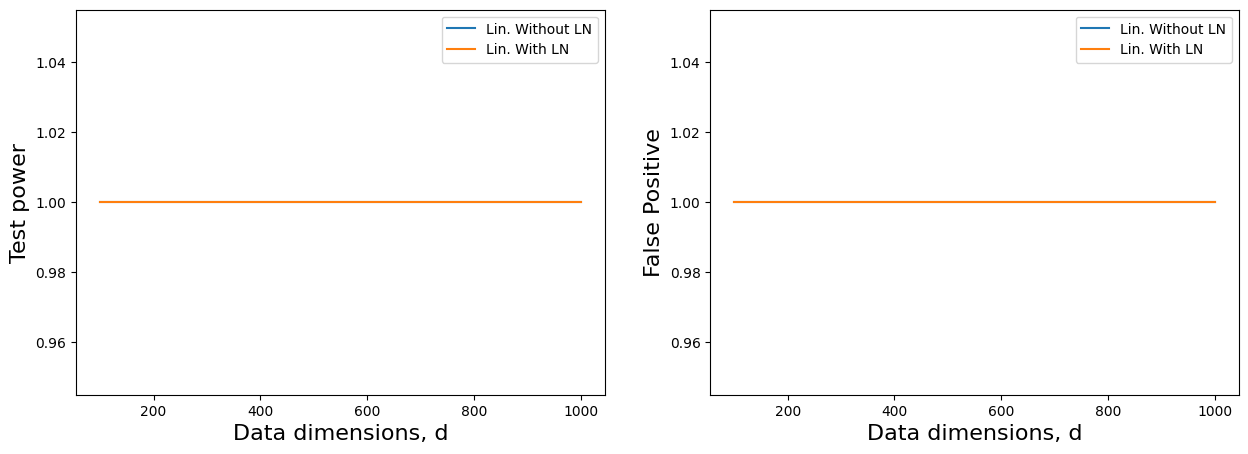

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(
    [key for key in lin_stat_beta.keys()],
    [1 - value for value in lin_stat_beta.values()],
    label="Lin. Without LN",
)

ax1.plot(
    [key for key in lin_stat_beta_ln.keys()],
    [1 - value for value in lin_stat_beta_ln.values()],
    label="Lin. With LN",
)

ax1.set_xlabel("Data dimensions, d", fontsize=16)
ax1.set_ylabel("Test power", fontsize=16)
ax1.legend()

ax2.plot(
    [key for key in lin_stat_beta.keys()],
    [value for value in lin_stat_alpha.values()],
    label="Lin. Without LN",
)

ax2.plot(
    [key for key in lin_stat_beta_ln.keys()],
    [value for value in lin_stat_alpha_ln.values()],
    label="Lin. With LN",
)

ax2.set_xlabel("Data dimensions, d", fontsize=16)
ax2.set_ylabel("False Positive", fontsize=16)
plt.legend()

In [185]:
dataset_parameters = {
    "dataset_size": 500,
    "seq_len": 101,
    "d": 100,
    "p": 5,
    "distribution": "t-distribution",
    "k": 10,
    "cp": None,
    "nu": 10
}

cp_parameters = {
    "alpha": 0.05,
    "ln": False,
    "scan": False,
    "data_based": True,
}

In [186]:
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
t_predicted_cp, likelihood_cp = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])
norm_predicted_cp, l_statistic = cpd.detect_cps_normal(t_data_with_cp, dataset_parameters, **cp_parameters)

In [187]:
t_predicted_cp

array([96, 86, 86, 86, 86, 87, 85, 84, 86, 16, 86, 85, 85, 85, 86, 95, 86,
       86, 86, 85, 85, 85, 86, 85, 86, 85, 86, 85, 85, 85, 84, 85, 85, 85,
       86, 85, 86, 96, 85, 95, 97, 85, 85, 85, 85, 86, 97, 85, 86, 86, 86,
       89, 86, 86, 85, 85, 85, 86, 86, 85, 86, 87, 85, 85, 86, 85, 86, 86,
       86, 96, 86, 85, 85, 86, 85, 85, 85, 95, 85, 86, 86, 86, 85, 85, 97,
       84, 86, 85, 86, 86, 85, 86, 85, 86, 86, 86, 85, 85, 85, 85, 85, 85,
       86, 86, 86, 96, 86, 85, 86, 87, 85, 85, 85, 86, 85, 86, 85, 86, 86,
       85, 85, 85, 86, 85, 85, 85, 86, 85, 85, 85, 86, 85, 85, 86, 85, 88,
       85, 86, 98, 85, 85, 85, 86, 93, 88, 85, 86, 85, 86, 85, 86, 85, 85,
       85, 86, 85, 85, 85, 86, 86, 86, 85, 86, 86, 85, 85, 85, 84, 85, 86,
       86, 96, 95, 95, 84, 85, 97, 85, 85, 99, 96, 85, 85, 86, 86, 99, 85,
       86, 85, 85, 86, 85, 86, 88, 85, 86, 90, 84, 92, 85, 85, 85, 85, 85,
       86, 85, 85, 85, 86, 87, 86, 85, 85, 85, 86, 84, 85, 85, 85, 85, 86,
       86, 85, 85, 86, 85

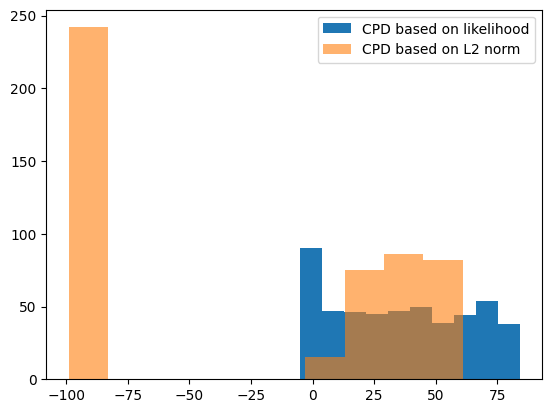

In [188]:
plt.hist(np.where(t_predicted_cp==-1, -99, t_predicted_cp - t_cp_idxs), label="CPD based on likelihood");
plt.hist(np.where(norm_predicted_cp==-1, -99, t_predicted_cp - t_cp_idxs), alpha=0.6, label="CPD based on L2 norm");
plt.legend();